In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, SimpleRNN
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_csv("/content/data.csv")
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.shape

(5842, 2)

### Text Processing

In [5]:
nlp_eng = spacy.load("en_core_web_sm")

In [6]:
sent = df.iloc[0,0]
sent

"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."

In [7]:
def text_process(text):
  remove_punc = "".join([x for x in text if x not in string.punctuation])
  doc = nlp_eng(remove_punc)
  lower_case = " ".join([x.text.lower() for x in doc if x.text!=" "])
  doc = nlp_eng(lower_case)
  remove_stp_wrd = " ".join([x.text for x in doc if not x.is_stop])
  doc = nlp_eng(remove_stp_wrd)
  lemma = " ".join([x.lemma_ for x in doc])
  return(lemma)

In [8]:
df["Sentence"] = df["Sentence"].map(lambda x: text_process(x))

Text(0, 0.5, 'Counts')

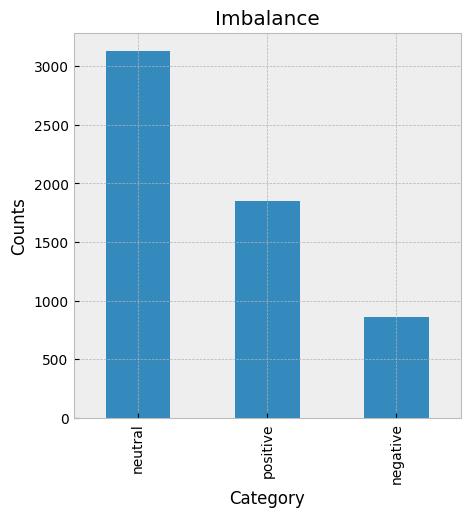

In [9]:
sentiment_count = df["Sentiment"].value_counts()
plt.style.use("bmh")
plt.figure(figsize=(5,5))
sentiment_count.plot.bar()
plt.title("Imbalance")
plt.xlabel("Category")
plt.ylabel("Counts")

In [10]:
max_category = sentiment_count.idxmax()
target_frequency = sentiment_count[max_category]
print(f"{max_category}: {target_frequency}")

neutral: 3130


In [11]:
strategy = {}
for x in sentiment_count.index:
  strategy[x] = target_frequency
strategy

{'neutral': 3130, 'positive': 3130, 'negative': 3130}

In [12]:
over_sampler = RandomOverSampler(sampling_strategy=strategy)
X = df["Sentence"].values.reshape((-1,1))
y = df["Sentiment"]

In [13]:
X_resamp, y_resamp = over_sampler.fit_resample(X, y)

In [14]:
y_resamp.value_counts()

positive    3130
negative    3130
neutral     3130
Name: Sentiment, dtype: int64

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resamp.reshape((-1,)))

In [20]:
vocab_size = len(tokenizer.word_index)
vocab_size

10896

In [17]:
sequences = tokenizer.texts_to_sequences(X_resamp.reshape((-1,)))
sequences[0]

[6561,
 79,
 2809,
 1794,
 3,
 2187,
 55,
 132,
 803,
 124,
 2188,
 79,
 1965,
 943,
 803,
 2189,
 3929,
 723,
 30,
 4951,
 540,
 172]

In [18]:
sequences = pad_sequences(sequences, padding="post")
sequences[:5]

array([[6561,   79, 2809, 1794,    3, 2187,   55,  132,  803,  124, 2188,
          79, 1965,  943,  803, 2189, 3929,  723,   30, 4951,  540,  172,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [4952,   47,  749, 1372, 3930,  429, 3305,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  17,   29,  561,    3,    8,    6,  541, 3931,   12, 4953,   12,
          13,   14,   48,  420, 4954,  111,    5,  111,   20, 1156,   12,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  81, 6562, 4955, 1966,  338,  125,    4,

In [21]:
input_length = sequences.shape[1]
input_length

46

In [31]:
labels = y_resamp.map({
    "negative": 0,
    "neutral": 1,
    "positive": 2
})
labels

0       2
1       0
2       2
3       1
4       1
       ..
9385    2
9386    2
9387    2
9388    2
9389    2
Name: Sentiment, Length: 9390, dtype: int64

In [67]:
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=10, input_length=input_length),
    SimpleRNN(64, return_sequences=False),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(3, activation="softmax")
])

rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 46, 10)            108960    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 64)                4800      
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)               

In [73]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=20,
                               min_delta=0.00001,
                               mode="min",
                               restore_best_weights=True)
rnn_model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
history = rnn_model.fit(sequences, labels ,
                        epochs=200,
                        validation_split=0.2,
                        callbacks=[early_stopping])

Epoch 1/200
235/235 [==============================] - 22s 81ms/step - loss: 0.4392 - accuracy: 0.8508 - val_loss: 0.5253 - val_accuracy: 0.8594
Epoch 2/200
235/235 [==============================] - 13s 54ms/step - loss: 0.4051 - accuracy: 0.8572 - val_loss: 0.3035 - val_accuracy: 0.8940
Epoch 3/200
235/235 [==============================] - 11s 48ms/step - loss: 0.4083 - accuracy: 0.8593 - val_loss: 0.3095 - val_accuracy: 0.9063
Epoch 4/200
235/235 [==============================] - 11s 49ms/step - loss: 0.3545 - accuracy: 0.8767 - val_loss: 0.2475 - val_accuracy: 0.9452
Epoch 5/200
235/235 [==============================] - 11s 46ms/step - loss: 0.3752 - accuracy: 0.8646 - val_loss: 0.2762 - val_accuracy: 0.9255
Epoch 6/200
235/235 [==============================] - 11s 47ms/step - loss: 0.3213 - accuracy: 0.8810 - val_loss: 0.1842 - val_accuracy: 0.9547
Epoch 7/200
235/235 [==============================] - 11s 49ms/step - loss: 0.6002 - accuracy: 0.7576 - val_loss: 0.9524 - val_ac

(0.0, 1.0)

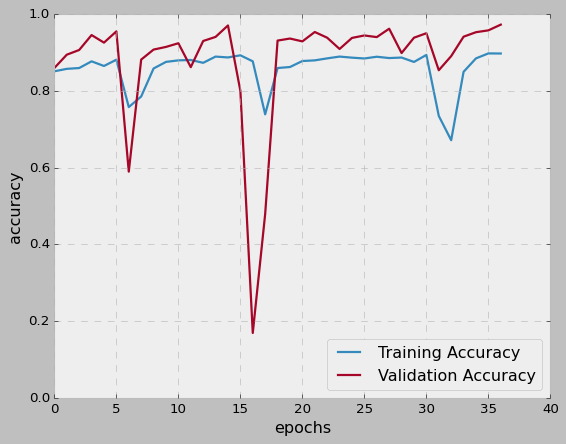

In [74]:
plt.style.use("bmh")
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.ylim(0.00, 1.00)